# Steepest Descent minimiser

In [1]:
import matplotlib.pyplot as plt
import fidimag
import fidimag.common.constant as C
import numpy as np
%matplotlib inline

In [2]:
# import imp
# imp.reload(fidimag)

## 1D example

We start defining parameters for an atomistic simulation

In [3]:
# System parameters
L = 100

# Some atomistic parameters
J = 5.88 * C.meV
D = 1.56 * C.meV
Ku = 0.41 * C.meV
mus = 3 * C.mu_B

# Lattice constants (in nm)
a = 0.2715
az = 0.408

# Magnetic field in Tesla
B = 2

# Free electron gyrom ratio
gamma = 1.76e11


Define the mesh of the system

In [4]:
nx, ny, nz = 100, 1, 1
dx, dy, dz = a, a, az

mesh = fidimag.common.CuboidMesh(nx=nx, ny=ny, nz=nz, dx=dx, dy=dy, dz=dz, 
                                periodicity=(False, False, False),
                                unit_length=1e-9)


### Steepest Descent

Here we set the minimiser by specifying it in the `driver` argument in the Simulation class:

In [5]:
sim = fidimag.atomistic.Sim(mesh, name='one_dim_SD', driver='hubert_minimiser')
       
# Define the magnetisation
sim.set_mu_s(mus)

# Add the magnetic interactions
sim.add(fidimag.atomistic.Exchange(J))
sim.add(fidimag.atomistic.Anisotropy(Ku, axis=(0, 0, 1)))
sim.add(fidimag.atomistic.DMI(D, dmi_type='interfacial'))
sim.add(fidimag.atomistic.Zeeman((0, 0, B)))

xs = mesh.coordinates[:, 0]
centre_x = (xs.max() + xs.min()) * 0.5 + xs.min() 
       
def m_initial(r):
    x, y, z = r[0], r[1], r[2]
    if np.abs(x - centre_x) < 2:
        return (0, 0.1, -.9)
    else:
        return (0, 0.1, .9)

# sim.set_m((0.1, 0, 0.9))
sim.set_m(m_initial)
# Set energy scale to Exchange:
sim.driver.energyScale = J

(100, 6)


The initial configuration showing $m_{z}$, we want a domain wall after relaxation:

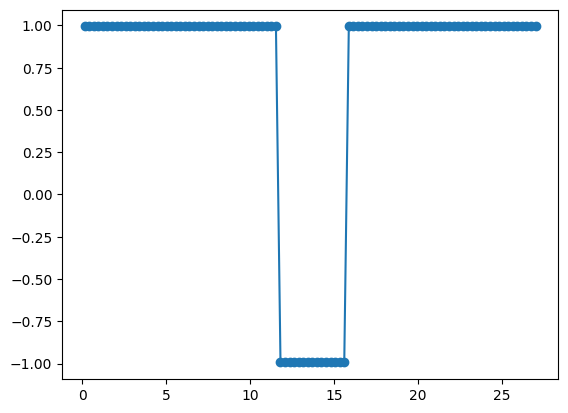

In [6]:
plt.plot(sim.mesh.coordinates[:, 0], sim.spin.reshape(-1, 3)[:, 2], 'o-')
plt.show()

Here we relax the system with the steepest descent. In this case, the relevant parameter to stop the minimisation is the `dm` difference of the magnetisation with the previous step:

In [7]:
sim.driver.minimise(stopping_dE=1e-3, eta_scale=1.0, maxCreep=4)

Step =    1 Creep n =   0  reset =   0  eta = 1.0000e+00  E_new = -1.0798e+02  ΔE = 1.0798e+01  max(∇E^2) = 5.7561e+03
Step =    2 Creep n =   1  reset =   0  eta = 1.0000e+00  E_new = -1.0893e+02  ΔE = 1.0893e+01  max(∇E^2) = 5.8215e+03
Step =    3 Creep n =   2  reset =   0  eta = 1.0000e+00  E_new = -1.0938e+02  ΔE = 1.0938e+01  max(∇E^2) = 5.8045e+03
Step =    4 Creep n =   3  reset =   0  eta = 1.0000e+00  E_new = -1.0966e+02  ΔE = 1.0966e+01  max(∇E^2) = 5.7800e+03
Step =    5 Creep n =   0  reset =   0  eta = 2.0000e+00  E_new = -1.0985e+02  ΔE = 1.0985e+01  max(∇E^2) = 5.7987e+03
Step =    6 Creep n =   1  reset =   0  eta = 2.0000e+00  E_new = -1.0999e+02  ΔE = 1.0999e+01  max(∇E^2) = 5.7766e+03
Step =    7 Creep n =   2  reset =   0  eta = 2.0000e+00  E_new = -1.1010e+02  ΔE = 1.1010e+01  max(∇E^2) = 5.7955e+03
Step =    8 Creep n =   3  reset =   0  eta = 2.0000e+00  E_new = -1.1018e+02  ΔE = 1.1018e+01  max(∇E^2) = 5.7713e+03
Step =    9 Creep n =   0  reset =   0  eta = 4.

The performance of the algorithm can be tuned by modifying the `tmax` and `tmin` tolerances in the driver. By defalt, `tmax` is around 0.01 (MuMax3 uses this magnitude) and `tmin` must be significantly small. These values seem to work reasonably well for most atomistic simulations:

We finally obtain the $360^\circ$ domain wall:

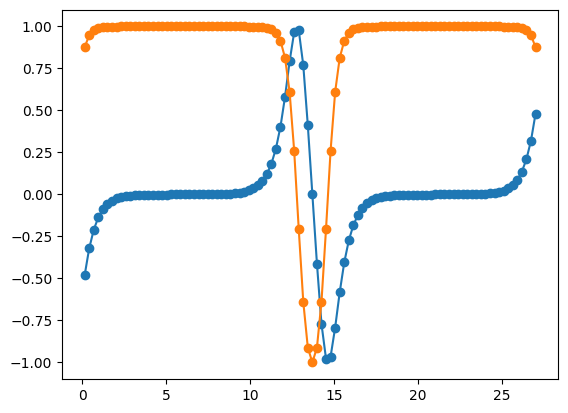

In [58]:
plt.plot(sim.mesh.coordinates[:, 0], sim.spin.reshape(-1, 3)[:, 0], 'o-')
plt.plot(sim.mesh.coordinates[:, 0], sim.spin.reshape(-1, 3)[:, 2], 'o-')
plt.show()

### LLG

We can compare the previous result with the LLG driver, which is widely tested:

In [12]:
sim = fidimag.atomistic.Sim(mesh, name='one_dim', driver='llg')
       
# Define the magnetisation
sim.set_mu_s(mus)

# Add the magnetic interactions
sim.add(fidimag.atomistic.Exchange(J))
sim.add(fidimag.atomistic.Anisotropy(Ku, axis=(0, 0, 1)))
sim.add(fidimag.atomistic.DMI(D, dmi_type='interfacial'))
sim.add(fidimag.atomistic.Zeeman((0, 0, B)))

xs = mesh.coordinates[:, 0]
centre_x = (xs.max() + xs.min()) * 0.5 + xs.min() 
       
def m_initial(r):
    x, y, z = r[0], r[1], r[2]
    if np.abs(x - centre_x) < 2:
        return (0, 0.1, -.9)
    else:
        return (0, 0.1, .9)

# sim.set_m((0.1, 0, 0.9))
sim.set_m(m_initial)

(100, 6)


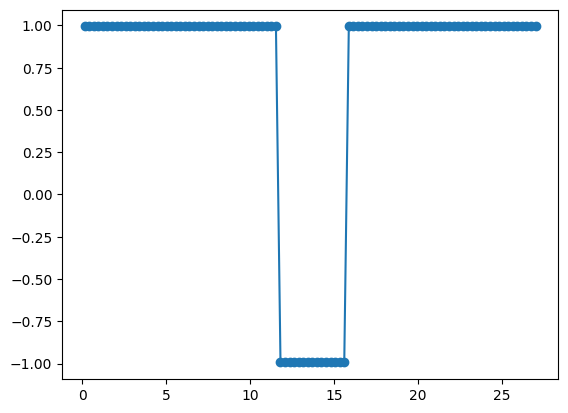

In [13]:
plt.plot(sim.mesh.coordinates[:, 0], sim.spin.reshape(-1, 3)[:, 2], 'o-')
plt.show()

In [14]:
sim.driver.do_precession = False
sim.relax()

#1    t=1e-11    dt=1e-11 max_dmdt=1.77
#2    t=3.53e-10 dt=3.43e-10 max_dmdt=1.77
#3    t=3.79e-09 dt=3.43e-09 max_dmdt=1.77
#4    t=3.81e-08 dt=3.43e-08 max_dmdt=1.77
#5    t=3.81e-07 dt=3.43e-07 max_dmdt=1.77
#6    t=3.81e-06 dt=3.43e-06 max_dmdt=1.77
#7    t=2.51e-05 dt=2.13e-05 max_dmdt=1.77
#8    t=8.19e-05 dt=5.67e-05 max_dmdt=1.77
#9    t=0.000197 dt=0.000115 max_dmdt=1.77
#10   t=0.000417 dt=0.00022 max_dmdt=1.77
#11   t=0.000637 dt=0.00022 max_dmdt=1.77
#12   t=0.000856 dt=0.00022 max_dmdt=1.77
#13   t=0.00108  dt=0.00022 max_dmdt=1.77
#14   t=0.00161  dt=0.000532 max_dmdt=1.78
#15   t=0.00214  dt=0.000532 max_dmdt=1.78
#16   t=0.00267  dt=0.000532 max_dmdt=1.78
#17   t=0.0032   dt=0.000532 max_dmdt=1.78
#18   t=0.00374  dt=0.000532 max_dmdt=1.79
#19   t=0.00483  dt=0.00109 max_dmdt=1.79
#20   t=0.00591  dt=0.00109 max_dmdt=1.8
#21   t=0.007    dt=0.00109 max_dmdt=1.8
#22   t=0.00809  dt=0.00109 max_dmdt=1.81
#23   t=0.00918  dt=0.00109 max_dmdt=1.82
#24   t=0.0109   dt=0.001

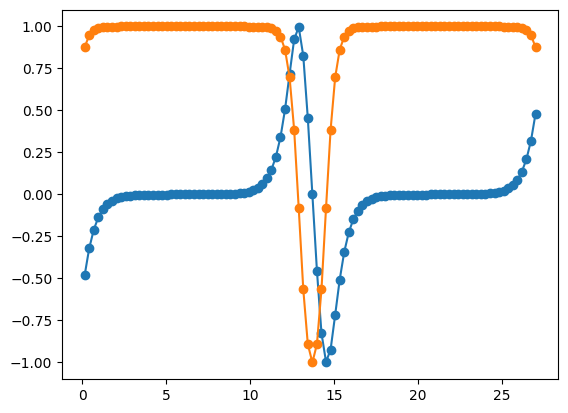

In [26]:
plt.plot(sim.mesh.coordinates[:, 0], sim.spin.reshape(-1, 3)[:, 0], 'o-')
plt.plot(sim.mesh.coordinates[:, 0], sim.spin.reshape(-1, 3)[:, 2], 'o-')
plt.show()

In [15]:
sim.field

array([-1.93776227e+01,  5.26249743e-06,  3.53252843e+01, -2.43022394e+01,
        1.06829905e-05,  7.17000261e+01, -1.58700306e+01,  1.08108601e-05,
        7.38926322e+01, -1.02504049e+01,  1.12013281e-05,  7.46113841e+01,
       -6.59398076e+00,  1.18018027e-05,  7.47707006e+01, -4.23646861e+00,
        1.25469154e-05,  7.47450765e+01, -2.72115868e+00,  1.33792647e-05,
        7.46752308e+01, -1.74798936e+00,  1.42543149e-05,  7.46082118e+01,
       -1.12302175e+00,  1.51401011e-05,  7.45559837e+01, -7.21595606e-01,
        1.60155425e-05,  7.45186318e+01, -4.63699427e-01,  1.68686401e-05,
        7.44930611e+01, -2.97982938e-01,  1.76949665e-05,  7.44759801e+01,
       -1.91479568e-01,  1.84966121e-05,  7.44647354e+01, -1.23016635e-01,
        1.92815248e-05,  7.44573990e+01, -7.89906315e-02,  2.00633606e-05,
        7.44526404e+01, -5.06570731e-02,  2.08616567e-05,  7.44495666e+01,
       -3.23905224e-02,  2.17025888e-05,  7.44475888e+01, -2.05662952e-02,
        2.26200482e-05,  

In [27]:
sim.compute_energy()

-1.0466532164749655e-19

## 2D skyrmion

A more complex example is a 2D skyrmion in a disk. We will use the minimiser to find the equilibrium state:

In [1]:
import matplotlib.pyplot as plt
import fidimag
import fidimag.common.constant as C
import numpy as np
%matplotlib inline

In [2]:
# System parameters
L = 100

# Some atomistic parameters
J = 5.88 * C.meV
D = 1.56 * C.meV
Ku = 0.41 * C.meV
mus = 3 * C.mu_B

# Lattice constants (in nm)
a = 0.2715
az = 0.408

# Magnetic field in Tesla
B = 2

# Free electron gyrom ratio
gamma = 1.76e11


In [3]:
nx, ny, nz = 100, 100, 1
dx, dy, dz = a, a, az

mesh = fidimag.common.CuboidMesh(nx=nx, ny=ny, nz=nz, dx=dx, dy=dy, dz=dz, 
                                periodicity=(False, False, False),
                                unit_length=1e-9)
xs = mesh.coordinates[:, 0]
ys = mesh.coordinates[:, 1]
centre_x = (xs.max() + xs.min()) * 0.5 + xs.min() 

### Steepest Descent

We can get the same result using the minimiser:

In [4]:
sim = fidimag.atomistic.Sim(mesh, name='two_dim_SD', driver='hubert_minimiser')
       
# Define the magnetisation
def material(r):
    x, y = r[0] - centre_x, r[1] - centre_x
    
    if x ** 2 + y ** 2 < (np.max(xs) - centre_x) ** 2:
        return mus
    else:
        return 0
    
sim.set_mu_s(material)
# sim.set_mu_s(mus)

# Add the magnetic interactions
sim.add(fidimag.atomistic.Exchange(J))
sim.add(fidimag.atomistic.Anisotropy(Ku, axis=(0, 0, 1)))
sim.add(fidimag.atomistic.DMI(D, dmi_type='interfacial'))
sim.add(fidimag.atomistic.Zeeman((0, 0, B)))
       
def m_initial(r):
    x, y = r[0] - centre_x, r[1] - centre_x
    if x ** 2 + y ** 2 < 1:
        return (0, 0, -1)
    else:
        return (0, 0, 1)

sim.set_m(m_initial)
sim.driver.energyScale = sim.get_interaction('Exchange').J

(10000, 6)


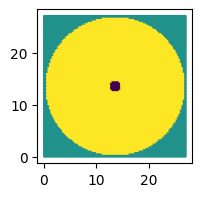

In [5]:
plt.figure(figsize=(2, 2))
plt.scatter(xs, ys, c=sim.spin.reshape(-1, 3)[:, 2], s=1)
plt.show()

In [6]:
sim.pins

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [7]:
for S in sim.interactions:
    print(S.name)
    print(S.energy[sim.pins == 0].min(), 
          S.energy[sim.pins == 0].max())
    print(S.energy)

Exchange
0.0 0.0
[0. 0. 0. ... 0. 0. 0.]
Anisotropy
0.0 0.0
[0. 0. 0. ... 0. 0. 0.]
DMI
0.0 0.0
[0. 0. 0. ... 0. 0. 0.]
Zeeman
0.0 0.0
[0. 0. 0. ... 0. 0. 0.]


In [12]:
sim.driver.field.reshape(-1, 3)[sim.driver._pins == 0]

array([[-14.55850089, -37.44096777,  62.30990993],
       [-11.20691509, -53.50494769,  94.01554272],
       [ -6.16665384, -52.584515  ,  94.66724194],
       ...,
       [  6.16665384,  52.584515  ,  94.66724194],
       [ 11.20691509,  53.50494769,  94.01554272],
       [ 14.55850089,  37.44096777,  62.30990993]])

In [13]:
sim.driver.gradE.reshape(-1, 3)[sim.driver._pins == 0]

array([[ 14.55850089,  37.44096777, -62.30990993],
       [ 11.20691509,  53.50494769, -94.01554272],
       [  6.16665384,  52.584515  , -94.66724194],
       ...,
       [ -6.16665384, -52.584515  , -94.66724194],
       [-11.20691509, -53.50494769, -94.01554272],
       [-14.55850089, -37.44096777, -62.30990993]])

In [9]:
# sim.driver.minimise(stopping_dE=1e-24, maxCreep=6, alpha_scale=1e-3)
sim.driver.minimise(stopping_dE=1e-4, maxCreep=6, eta_scale=1.)

Step =    1 Creep n =   0  reset =   0  eta =      1.0  E_new = -1.5777e+04  ΔE = 1.5777e+03  max(∇E^2) = 2.0675e+04
Step =    2 Creep n =   1  reset =   0  eta =      1.0  E_new = -1.5794e+04  ΔE = 1.5794e+03  max(∇E^2) = 2.0753e+04
Step =    3 Creep n =   2  reset =   0  eta =      1.0  E_new = -1.5806e+04  ΔE = 1.5806e+03  max(∇E^2) = 2.0798e+04
Step =    4 Creep n =   3  reset =   0  eta =      1.0  E_new = -1.5812e+04  ΔE = 1.5812e+03  max(∇E^2) = 2.0813e+04
Step =    5 Creep n =   4  reset =   0  eta =      1.0  E_new = -1.5816e+04  ΔE = 1.5816e+03  max(∇E^2) = 2.0819e+04
Step =    6 Creep n =   5  reset =   0  eta =      1.0  E_new = -1.5819e+04  ΔE = 1.5819e+03  max(∇E^2) = 2.0819e+04
Step =    7 Creep n =   0  reset =   0  eta =      2.0  E_new = -1.5821e+04  ΔE = 1.5821e+03  max(∇E^2) = 2.0815e+04
Step =    8 Creep n =   1  reset =   0  eta =      2.0  E_new = -1.5822e+04  ΔE = 1.5822e+03  max(∇E^2) = 2.0811e+04
Step =    9 Creep n =   2  reset =   0  eta =      2.0  E_new = 

In [7]:
_material = ~(np.repeat(sim.driver._pins, 3).astype(bool))
_material.reshape(-1, 3)[sim.driver._magnetisation > 0.0] = True


In [11]:
sim.driver.gradE[_material].reshape(-1, 3)

array([[   8.95332452,   11.75711122,  -74.26461811],
       [   4.07056074,   15.73313013, -108.75997164],
       [  -0.        ,   14.53070981, -108.06145945],
       ...,
       [  -0.        ,  -14.53070981, -108.06145945],
       [  -4.07056074,  -15.73313013, -108.75997164],
       [  -8.95332452,  -11.75711122,  -74.26461811]])

In [20]:
sim.driver.spin.shape

(30000,)

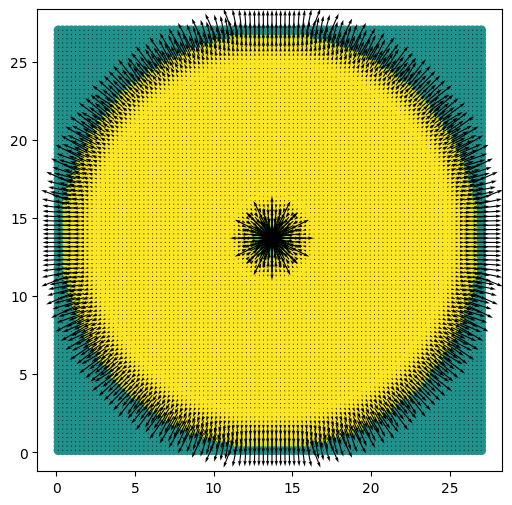

In [14]:
plt.figure(figsize=(6, 6))
plt.scatter(xs, ys, c=sim.spin.reshape(-1, 3)[:, 2], vmin=-1, vmax=1)

plt.quiver(xs, ys, sim.spin.reshape(-1, 3)[:, 0], sim.spin.reshape(-1, 3)[:, 1])
plt.show()

# Micromagnetics

In [8]:
import matplotlib.pyplot as plt
import fidimag
import fidimag.common.constant as C
import numpy as np
%matplotlib inline

In [9]:
nx, ny, nz = 100, 1, 1
dx, dy, dz = 1, 1, 1

mesh = fidimag.common.CuboidMesh(nx=nx, ny=ny, nz=nz, dx=dx, dy=dy, dz=dz, 
                                periodicity=(False, False, False),
                                unit_length=1e-9)

In [14]:
sim = fidimag.micro.Sim(mesh, name='1Dmicro', driver='hubert_minimiser')

Ms = 0.86e6
A = 13e-12
Ku = 0.4e6

# Define the magnetisation
sim.set_Ms(Ms)

# Add the magnetic interactions
sim.add(fidimag.micro.UniformExchange(A))
sim.add(fidimag.micro.UniaxialAnisotropy(Ku, axis=(0, 0, 1)))
# sim.add(fidimag.atomistic.DMI(D, dmi_type='interfacial'))
# sim.add(fidimag.micro.Zeeman((0, 0, B)))

xs = mesh.coordinates[:, 0]
centre_x = (xs.max() + xs.min()) * 0.5 + xs.min() 
       
def m_initial(r):
    x, y, z = r[0], r[1], r[2]
    if x < centre_x:
        return (0, 0.1, -.9)
    else:
        return (0, 0.1, .9)

# sim.set_m((0.1, 0, 0.9))
sim.set_m(m_initial)

mesh_vol = mesh.n * mesh.dx * mesh.dy * mesh.dz * 1e-27
Kd = C.mu_0 * (Ms ** 2) * 0.5 * mesh_vol
sim.driver.energyScale = Kd

In [15]:
sim.driver.field.reshape(-1, 3)[:3]

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [16]:
# sim.driver.minimise(stopping_dE=1e-4, maxCreep=6, eta_scale=C.mu_0)
sim.driver.minimise(stopping_dE=1e-5, maxCreep=6, eta_scale=1e-6, log_steps=10)

Step =   10 Creep n =   0  reset =   0  eta = 3.1250e-02  E_new = 3.3533e-01  ΔE = 3.0226e-01  max(∇E^2) = 2.9932e+13
Step =   20 Creep n =   3  reset =   0  eta = 1.5625e-02  E_new = 2.4027e-01  ΔE = 6.6133e-03  max(∇E^2) = 5.4185e+12
Step =   30 Creep n =   0  reset =   0  eta = 1.5625e-02  E_new = 2.1691e-01  ΔE = 2.0841e-03  max(∇E^2) = 2.8302e+12
Step =   40 Creep n =   4  reset =   0  eta = 3.1250e-02  E_new = 2.0722e-01  ΔE = 8.4177e-04  max(∇E^2) = 1.7757e+12
Step =   50 Creep n =   1  reset =   0  eta = 3.1250e-02  E_new = 2.0337e-01  ΔE = 3.9359e-04  max(∇E^2) = 1.2702e+12
Step =   60 Creep n =   4  reset =   0  eta = 1.5625e-02  E_new = 2.0022e-01  ΔE = 2.6369e-04  max(∇E^2) = 1.0068e+12
Step =   70 Creep n =   1  reset =   0  eta = 1.5625e-02  E_new = 1.9872e-01  ΔE = 1.3646e-04  max(∇E^2) = 8.7661e+11
Step =   80 Creep n =   5  reset =   0  eta = 3.1250e-02  E_new = 1.9766e-01  ΔE = 9.7069e-05  max(∇E^2) = 7.8299e+11
Step =   90 Creep n =   2  reset =   0  eta = 3.1250e-02

In [17]:
def mz_dw_analyt(x, xc):
    deltaB = np.sqrt(A / Ku)
    return np.tanh((x - xc) / deltaB)

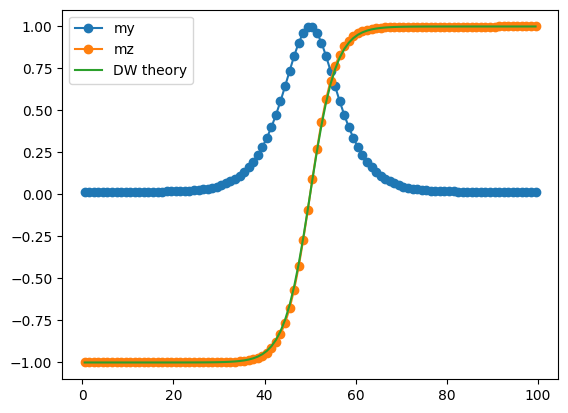

In [18]:
my, mz = sim.spin.reshape(-1, 3)[:, 1], sim.spin.reshape(-1, 3)[:, 2]

f, ax = plt.subplots()

ax.plot(sim.mesh.coordinates[:, 0], my, 'o-', label='my')
ax.plot(sim.mesh.coordinates[:, 0], mz, 'o-', label='mz')

x = sim.mesh.coordinates[:, 0]
y = mz_dw_analyt(x * 1e-9, 50 * 1e-9)
ax.plot(x, y, label='DW theory')

ax.legend()

plt.show()

In [72]:
# Root mean squareed error
# np.sqrt(np.mean((y - mz) ** 2))
RMSE = np.linalg.norm(y - mz) / np.sqrt(len(mz))
print(RMSE)

0.007070004503369823


In [73]:
# Mean absolute error
MAE = np.mean(np.abs(y - mz))
print(MAE)

0.0036582403059809256


In [74]:
# Mean absolute error at points within the DW width:
deltaB = np.sqrt(A / Ku) * 1e9
xc = 50  # sample centre
ftr = np.logical_and(x <= xc + deltaB, x >= xc - deltaB)

MAE_dw = np.mean(np.abs(y[ftr] - mz[ftr]))
print(MAE_dw)

0.014763571008345598


In [ ]:
# The maximum variability should be 2 since mz E [-1, 1], therefore
# the MAE_dw is relatively small

## 2D Skyrmion model

In [19]:
import scipy

In [20]:
# System parameters
nm = 1e-9
radius = 50 * nm        # sample radius in nm
thickness = 2 * nm
cell = 2 * nm

# scales in nm
radius_s = radius / nm
thickness_s = thickness / nm
cell_s = cell / nm

# Permalloy-like material (for testing purposes)
A = 13e-12
D = 3e-3
Ku = 0.4e6
Ms = 0.86e6

print('H_D = ', (1e9) * 4 * np.pi * A / D, ' nm')

H_D =  54.454272662223076  nm


In [21]:
dx, dy, dz = cell_s, cell_s, cell_s
nx, ny, nz = int(2 * radius_s / dx), int(2 * radius_s / dy), 1
mesh = fidimag.common.CuboidMesh(dx=dx, dy=dy, dz=dz, nx=nx, ny=ny, nz=nz,
                                 unit_length=1e-9)

sim = fidimag.micro.Sim(mesh, name='fidimag_2D_int', driver='hubert_minimiser')

# To define the nanodisk:
def Ms_fun(pos):
    x, y = np.array(pos)[:2] - radius_s
    if (x ** 2 + y ** 2) ** 0.5 < radius_s:
        return Ms
    else:
        return 0

# Make spins point in the opposite direction in a small circular region at
# the middle of the sample to get a skyrmion
def m_init(pos):
    x, y = np.array(pos)[:2] - radius_s
    if (x ** 2 + y ** 2) ** 0.5 < radius_s / 2:
        return (0, 0.1, 1)
    else:
        return (0, 0.1, -1)

sim.set_Ms(Ms_fun)
sim.set_m(m_init)
sim.add(fidimag.micro.UniformExchange(A=A))
sim.add(fidimag.micro.UniaxialAnisotropy(Ku, axis=(0, 0, 1)))
sim.add(fidimag.micro.DMI(D=D, dmi_type='interfacial'))

mesh_vol = mesh.n * mesh.dx * mesh.dy * mesh.dz * 1e-27
Kd = C.mu_0 * (Ms ** 2) * 0.5 * mesh_vol
sim.driver.energyScale = Kd

In [22]:
sim.driver.minimise(stopping_dE=1e-9, maxCreep=6, eta_scale=1e-5, log_steps=100, max_steps=4000)

Step =  100 Creep n =   4  reset =   0  eta = 3.9062e-03  E_new = -5.5037e-02  ΔE = 5.4569e-06  max(∇E^2) = 1.0254e+12
Step =  200 Creep n =   0  reset =   0  eta = 3.9062e-03  E_new = -5.5183e-02  ΔE = 4.7759e-07  max(∇E^2) = 1.0215e+12
Step =  300 Creep n =   2  reset =   0  eta = 1.9531e-03  E_new = -5.5281e-02  ΔE = 7.0442e-07  max(∇E^2) = 1.0234e+12
Step =  400 Creep n =   5  reset =   0  eta = 3.9062e-03  E_new = -5.5356e-02  ΔE = 8.0693e-07  max(∇E^2) = 1.0267e+12
Step =  500 Creep n =   2  reset =   0  eta = 1.5625e-02  E_new = -5.5416e-02  ΔE = 8.3045e-07  max(∇E^2) = 1.0295e+12
Step =  600 Creep n =   4  reset =   0  eta = 7.8125e-03  E_new = -5.5463e-02  ΔE = 3.9671e-07  max(∇E^2) = 1.0321e+12
Step =  700 Creep n =   0  reset =   0  eta = 7.8125e-03  E_new = -5.5502e-02  ΔE = 2.0559e-07  max(∇E^2) = 1.0345e+12
Step =  800 Creep n =   2  reset =   0  eta = 3.9062e-03  E_new = -5.5533e-02  ΔE = 2.0815e-07  max(∇E^2) = 1.0367e+12
Step =  900 Creep n =   4  reset =   0  eta = 1.

In [23]:
# ODE solution
# Use units in the nm scale
delta = (np.sqrt(A / Ku)) / nm
xi = (2 * A / D) / nm 
r_array = np.linspace(1e-15, radius_s, 500)

def ode_2d(theta, r):
    '''
    ODE for boundary value problem (function given at r = 0, derivative of 
    function given at r = R )
    '''
    return np.array([theta[1],
                     -theta[1] / r + 0.5 * np.sin(2 * theta[0]) * ((1 / r ** 2) + (1 / delta ** 2)) 
                     + 2 * (np.sin(theta[0]) ** 2) / (xi * r)])


# Define a function to solve the differential equation in the (0, R) range
# for any theta'(r=0) condition. We need theta'(r=R) = 1/xi
# The function returns the difference of theta' with respect to the desired solution at r=R
def solve_ode(a):
    solution, info = scipy.integrate.odeint(ode_2d, [0, a], r_array, full_output=True)
    return solution[:, 1][-1] - (1 / xi)

# Find the root from the differences:
guess = []
guess.append(scipy.optimize.brentq(solve_ode, 0, 0.05))

solutions = []
for g in guess:
    solution, info = scipy.integrate.odeint(ode_2d, [0, g], r_array, full_output=True)
    solutions.append(solution)

r_theory = r_array
mz_theory = np.cos(solutions[0][:, 0])

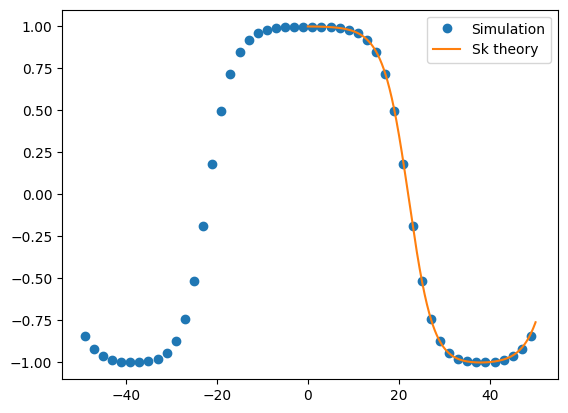

In [26]:
mz = sim.spin.reshape(-1, 3)[:, 2]
x, y = sim.mesh.coordinates[:, 0], sim.mesh.coordinates[:, 1]
# Take coordinates from the centre: y == 51.
_filter_y = y == np.unique(y)[int(len(np.unique(y)) * 0.5)]

f, ax = plt.subplots()

# ax.plot(, mz, 'o-', label='mz')
plt.plot(x[_filter_y] - 50, mz[_filter_y], 'o', label='Simulation')

ax.plot(r_theory, mz_theory, label='Sk theory')

ax.legend()

plt.show()

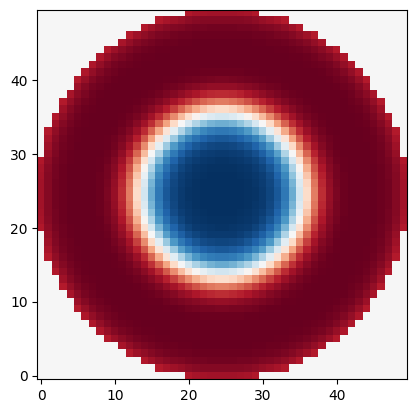

In [27]:
f, ax = plt.subplots()
ax.imshow(mz.reshape(mesh.ny, mesh.ny), origin='lower', cmap='RdBu', vmin=-1, vmax=1)